In [1]:
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
#opens .dat files to be converted into CSVs
#change pathprefix on different computers
EOS_files = "/home/tplohr/proj/SF 24-25/diettim NMMA master EOS-chiralEFT_MTOV/"

def loadfile(number):
    file = open(EOS_files + str(number) + '.dat', 'r')
    return file

In [3]:
#creates an empty array to contain all EOSs 
numofEOS = 5000
EOSs = [None] * numofEOS

#fills "EOSs" with arrays of each EOS's mass and radius values 
for i in range(numofEOS):
    df = pd.read_csv(loadfile(i+1), delimiter = '\t', names = ["radius", "mass", "deformability"])
    EOSs[i] = np.array([df["radius"], df["mass"]])
#EOSs[i] is EOS_i
#EOSs[i][0] is the list of radius values of EOS_i
#EOSs[i][1] is the list of mass values of EOS_i
#EOSs[i][0][j] is the radius value indexed j of EOS_i
#EOSs[i][1][j] is the mass value indexed j of EOS_i

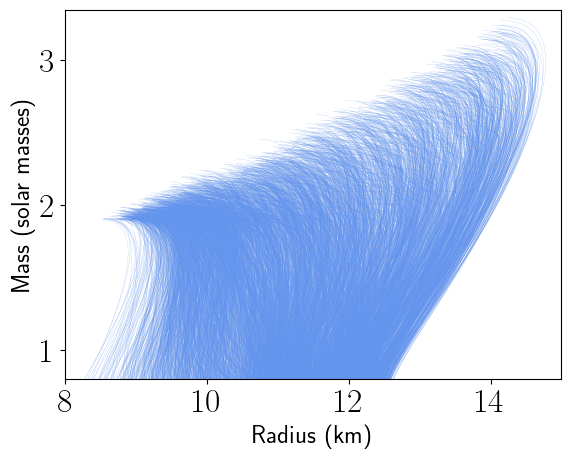

In [4]:
#plots each EOS 
for i in range(numofEOS):
    plt.xlim([8,15])
    plt.ylim([.8,3.35])
    plt.xlabel("Radius (km)", fontsize=18)
    plt.ylabel("Mass (solar masses)", fontsize=18)
    plt.rcParams['figure.figsize'] = [9,5]
    plt.plot(EOSs[i][0], EOSs[i][1], 'cornflowerblue', linewidth=.1)

In [5]:
#finding the closest mass values to 1.4 

#n is the EOS index 1-5000
def closest_points(n):
    #initial smallest distance for mass values smaller and larger than 1.4
    closest_smaller_dis = 10

    #loop for every value of mass in EOS_n
    for j in range(len(EOSs[n-1][1])):
        #distance between mass value, indexed j, and 1.4
        dis = EOSs[n-1][1][j] - 1.4

        #if the absolute distance is smaller than the current closest distance and the mass value is less than 1.4
        if(abs(dis) < closest_smaller_dis and dis < 0):
            #the current closest distance (where the mass is less than 1.4) is updated
            closest_smaller_dis = abs(dis)
            #the EOS mass index is stored
            closest_smaller_EOS = j
            #since the .dat files are sorted from lowest mass to greatest, the closest mass value that is greater than 1.4 is the row after the closest smaller mass value
            closest_larger_EOS = j+1
            
    return closest_smaller_EOS, closest_larger_EOS

In [6]:
#arrays to store the closest mass values
#each index coresponds to the index of the EOS
closest_smaller_points = np.zeros(numofEOS)
closest_larger_points = np.zeros(numofEOS)
for n in range(numofEOS):
     closest_smaller_points[n], closest_larger_points[n] = closest_points(n+1)

In [7]:
print(closest_smaller_points)
print(closest_larger_points)

[58. 58. 58. ... 81. 72. 74.]
[59. 59. 59. ... 82. 73. 75.]


In [8]:
#list of the interpolated radius at 1.4 solar masses for each EOS
interp_radius = np.zeros(numofEOS)

#calculates the interpolated radius for one EOS
def interp(EOSnum):
    #the closest mass values and their respective radi
    smaller_mass = EOSs[EOSnum-1][1][int(closest_smaller_points[EOSnum-1])]
    larger_mass = EOSs[EOSnum-1][1][int(closest_larger_points[EOSnum-1])]
    radius_of_smaller_mass = EOSs[EOSnum-1][0][int(closest_smaller_points[EOSnum-1])]
    radius_of_larger_mass = EOSs[EOSnum-1][0][int(closest_larger_points[EOSnum-1])]
    #dif between 1.4 and the closest mass value less than 1.4
    a = 1.4 - smaller_mass
    #dif between closest mass value more than 1.4 and the closest mass value less than 1.4
    c = larger_mass - smaller_mass
    #dif between the radius value of the closest mass value more than 1.4 and the radius value at the closest mass value less than 1.4
    d = radius_of_larger_mass - radius_of_smaller_mass
    #calculation using ratios of differences 
    interp_radius[EOSnum-1] = d * a / c + radius_of_smaller_mass
    
    return interp_radius

In [9]:
for i in range(numofEOS):
    interp(i)
print(interp_radius)

[13.26412043 13.33871273 13.15281871 ... 10.68539829 11.96835397
 11.57790336]


In [10]:
sigma = 0.8
mu = 11.8

In [11]:
def gaussian(x, mu, sigma):
    return np.exp(-(x - mu)**2/(2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)

In [12]:
#initialization of probability arrays

#probabilities of the EOSs given the observations, each index corresponds to one EOS; posterior
P_EOS_given_obs = np.zeros(numofEOS)
#probabilities of the observations given an EOS; likelihood
P_obs_given_EOS = np.zeros(numofEOS)
#probabilities of the EOSs without a condition; prior
P_EOS = np.zeros(numofEOS)

In [13]:
norm_factor = 0
for i in range(numofEOS):
    #calculate the likelihood
    P_obs_given_EOS[i] = gaussian(interp_radius[i], mu, sigma)
    #calculate the denominator (sum of the numerator)
    norm_factor += P_obs_given_EOS[i]

for i in range(numofEOS):
    #calculate the posterior
    P_EOS_given_obs[i] = P_obs_given_EOS[i] / norm_factor

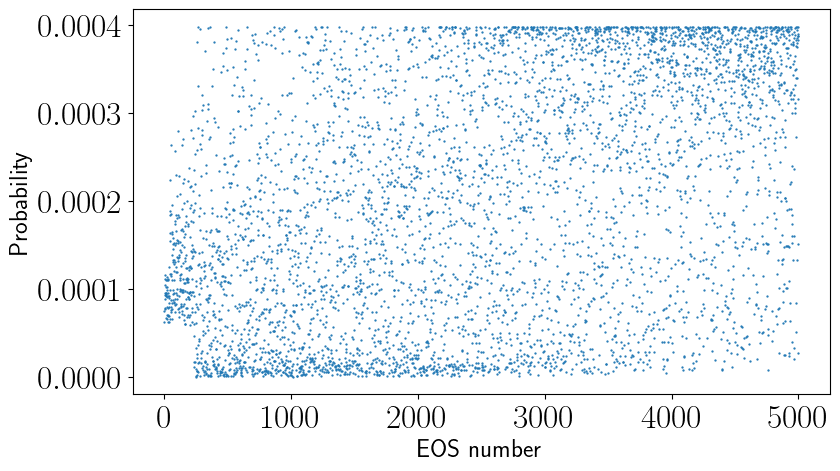

In [14]:
plt.scatter(np.linspace(0,numofEOS,5000), P_EOS_given_obs, s=0.4)
plt.xlabel("EOS number", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.rcParams['figure.figsize'] = [6,4]

In [15]:
tot_prob = 0
for i in range(numofEOS):
    tot_prob += P_EOS_given_obs[i]
print(tot_prob)

1.000000000000001


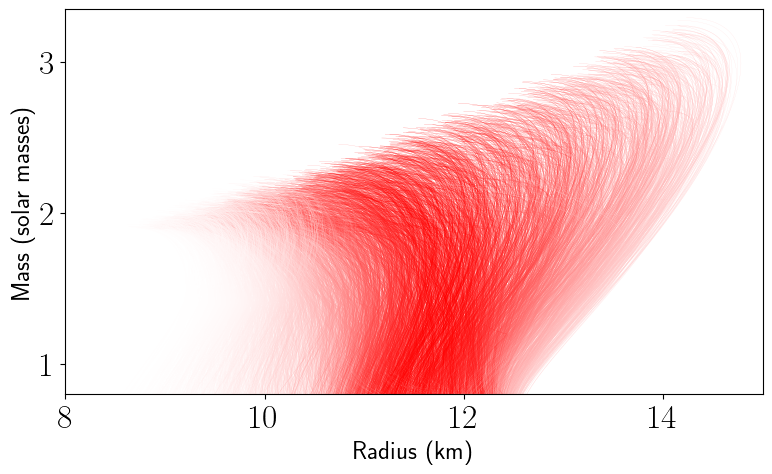

In [19]:
#plotting each EOS; low probability is white, high probability is red
cmap = mp.colors.LinearSegmentedColormap.from_list("white_to_red", ["white","red"])
norm = plt.Normalize(P_EOS_given_obs.min(), P_EOS_given_obs.max())
#plots each EOS 
for i in range(numofEOS):
    color = cmap(norm(P_EOS_given_obs[i]))
    plt.xlim([8,15])
    plt.ylim([.8,3.35])
    plt.xlabel("Radius (km)", fontsize=18)
    plt.ylabel("Mass (solar masses)", fontsize=18)
    plt.rcParams['figure.figsize'] = [9,5]
    plt.plot(EOSs[i][0], EOSs[i][1], color=color, linewidth=.1)